# Import LightSheet Dataset

The LightSheet dataset is composed of a sequence of tiles of the same region with different noise levels.  <br>
With the import_dataset('ls_**mode**'), it's possible to import the lightsheet dataset with different input, targets.  <br>
Possible Lightsheet Input-Target are: <br>

* 'ls_full' --> return the full series for every frame <br>
* 'ls_random' --> return as x the image with less noise and as y a random image in the sequence with more noise <br>
* 'ls_aedp' --> return as x the image with less noise and as y the x image with intensity decreased by a factor 0.5 with the dp API <br>
* 'ls_aedpdown**scale-factor**' -->  <br>
* 'ls_aedpdownup**scale-factor**' -->  <br>

In [155]:
from tqdm import tqdm
import torch
import numpy as np
from utils.ls_dataset import import_ls
import matplotlib.pyplot as plt
from torchvision import transforms as T

from utils.base import show_fig

from utils.augmentation import ComposeState

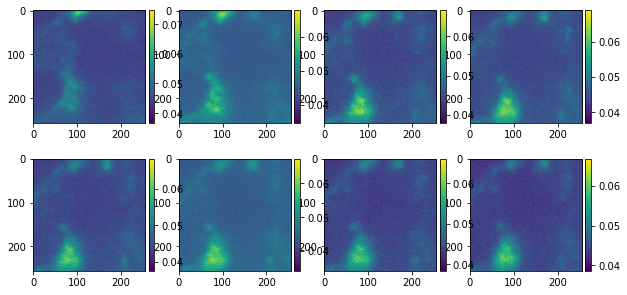

In [156]:
name = 'ls_full'
transform = T.Lambda(lambda x: (x/10852.0))

train_loader, valid_loader = import_ls(
                                        name=name, 
                                        batch_size=32, 
                                        image_size = 256,
                                        transform=transform,
                                        force_download = False)

x,y = next(iter(valid_loader))
imgs = [img for img in y[0,0]]
show_fig(imgs[:8], norm=False, colorbar = True)

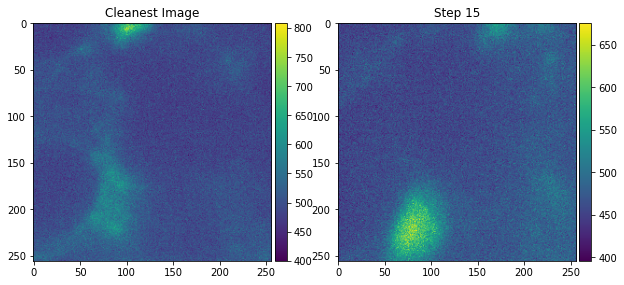

In [9]:
name = 'ls_step15'

train_loader, valid_loader = import_ls(
                                        name=name, 
                                        batch_size=32, 
                                        image_size = 256,
                                        force_download = False)

x,y = next(iter(valid_loader))
show_fig([x[0,0],y[0,0]], ax_titles=['Cleanest Image', 'Step 15'], norm=False, colorbar = True)

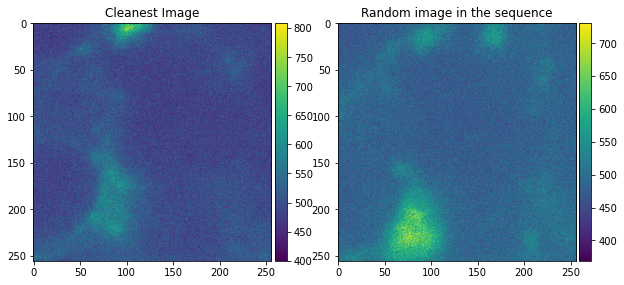

In [10]:
name = 'ls_random'

train_loader, valid_loader = import_ls(
                                        name=name, 
                                        batch_size=32, 
                                        image_size = 256,
                                        force_download = False)

x,y = next(iter(valid_loader))
show_fig([x[0,0],y[0,0]], ax_titles=['Cleanest Image', 'Random image in the sequence'], norm=False, colorbar = True)

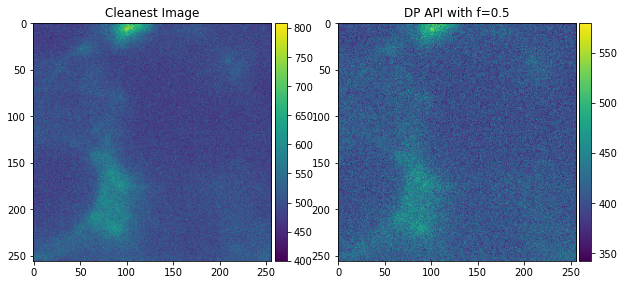

In [4]:
name = 'ls_aedp'

train_loader, valid_loader = import_ls(name=name, 
                                        batch_size=32, 
                                        image_size = 256,
                                        force_download = False)

x,y = next(iter(valid_loader))
show_fig([x[0,0],y[0,0]], ax_titles=['Cleanest Image', 'DP API with f=0.5'], norm=False, colorbar = True)

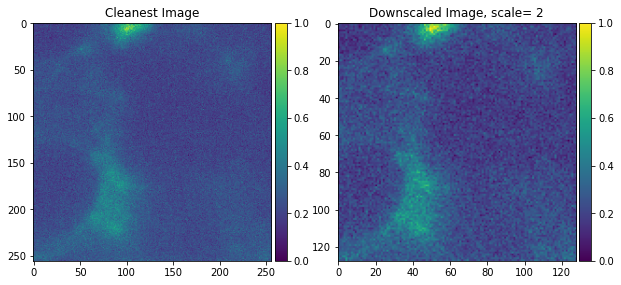

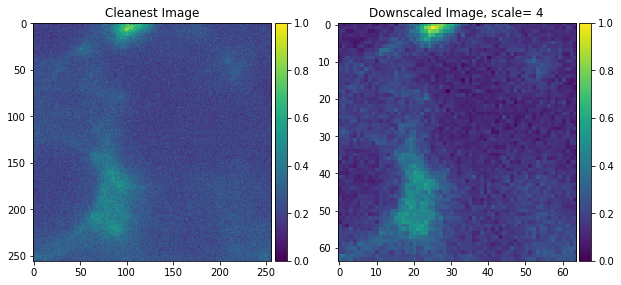

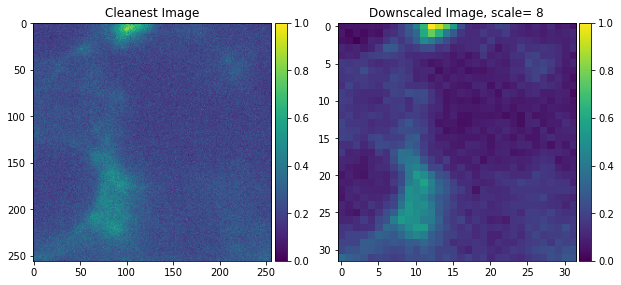

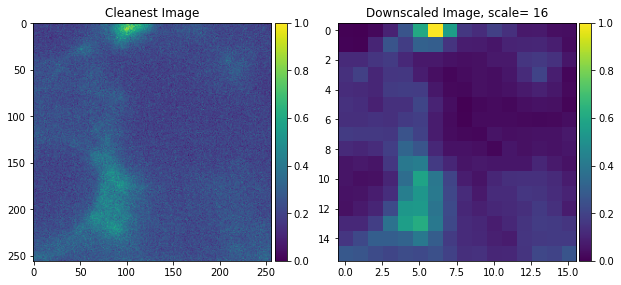

In [2]:
for scale in [2,4,8,16]:
    name = f'ls_aedpdown{scale:02d}'

    train_loader, valid_loader = import_ls(name=name, 
                                                batch_size=32, 
                                                image_size = 256,
                                                force_download = False)

    x,y = next(iter(valid_loader))
    show_fig([x[0,0],y[0,0]], ax_titles=[f'Cleanest Image', f'Downscaled Image, scale= {scale}'], colorbar = True)

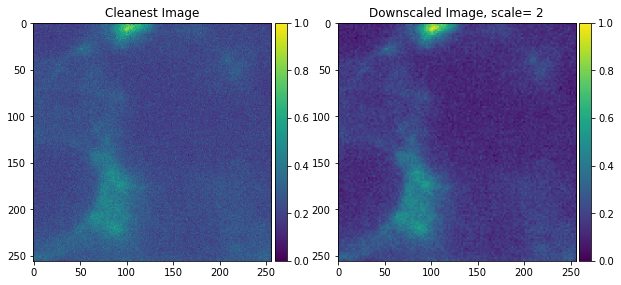

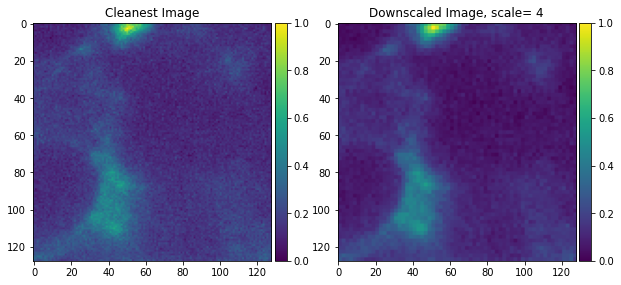

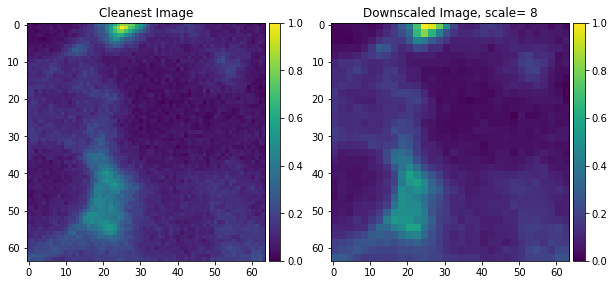

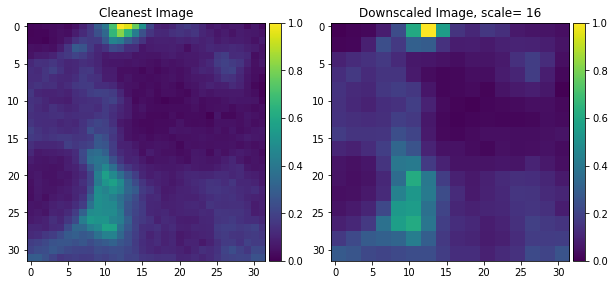

In [7]:
for scale in [2,4,8,16]:
    name = f'ls_aedownup{scale:02d}'

    train_loader, valid_loader = import_ls(name=name, 
                                                batch_size=32, 
                                                image_size = 256,
                                                force_download = False)

    x,y = next(iter(valid_loader))
    show_fig([x[0,0],y[0,0]], ax_titles=['Cleanest Image', f'Downscaled Image, scale= {scale}'], colorbar = True)

# Cavvy Filter 

Trying to use Cavvy Filter to obtain edges for sequence detection

In [119]:
import torch.nn as nn
import cv2

class CannyFilter(nn.Module):
    def __init__(self,
                 k_gaussian=3,
                 mu=0,
                 sigma=1,
                 k_sobel=3,
                 use_cuda=False):
        super(CannyFilter, self).__init__()
        # device
        self.device = 'cuda' if use_cuda else 'cpu'

        # gaussian

        gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)
        self.gaussian_filter.weight = torch.nn.Parameter( torch.from_numpy(gaussian_2D)[None,None].float(), requires_grad=True)
        

        # sobel

        sobel_2D = get_sobel_kernel(k_sobel)
        self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_x.weight = torch.nn.Parameter( torch.from_numpy(sobel_2D)[None,None].float(), requires_grad=True)


        self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_y.weight = torch.nn.Parameter( torch.from_numpy(sobel_2D.T)[None,None].float(), requires_grad=True)


        # thin

        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        self.directional_filter.weight = torch.nn.Parameter( torch.from_numpy(directional_kernels)[:,None].float(), requires_grad=True)

        # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    padding=1,
                                    bias=False)
        self.hysteresis.weight = torch.nn.Parameter( torch.from_numpy(hysteresis)[None,None].float(), requires_grad=True)


    def forward(self, img, low_threshold=None, high_threshold=None, hysteresis=False):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W)).to(self.device)
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)

        # gaussian

        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        # thick edges

        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180 # convert to degree
        grad_orientation = torch.round(grad_orientation / 45) * 45  # keep a split by 45

        # thin edges

        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])

            # get the local maximum pixels for the angle
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)

            # apply non maximum suppression
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds

        if low_threshold is not None:
            low = thin_edges > low_threshold

            if high_threshold is not None:
                high = thin_edges > high_threshold
                # get black/gray/white only
                thin_edges = low * 0.5 + high * 0.5

                if hysteresis:
                    # get weaks and check if they are high or not
                    weak = (thin_edges == 0.5) * 1
                    weak_is_high = (self.hysteresis(thin_edges) > 1) * weak
                    thin_edges = high * 1 + weak_is_high * 1
            else:
                thin_edges = low * 1


        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges
    

def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D


def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D


def get_thin_kernels(start=0, end=360, step=45):
        k_thin = 3  # actual size of the directional kernel
        # increase for a while to avoid interpolation when rotating
        k_increased = k_thin + 2

        # get 0° angle directional kernel
        thin_kernel_0 = np.zeros((k_increased, k_increased))
        thin_kernel_0[k_increased // 2, k_increased // 2] = 1
        thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

        # rotate the 0° angle directional kernel to get the other ones
        thin_kernels = []
        for angle in range(start, end, step):
            (h, w) = thin_kernel_0.shape
            # get the center to not rotate around the (0, 0) coord point
            center = (w // 2, h // 2)
            # apply rotation
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

            # get the k=3 kerne
            kernel_angle = kernel_angle_increased[1:-1, 1:-1]
            is_diag = (abs(kernel_angle) == 1)      # because of the interpolation
            kernel_angle = kernel_angle * is_diag   # because of the interpolation
            thin_kernels.append(kernel_angle)
        return thin_kernels

In [ ]:
!pip install opencv-python-headless

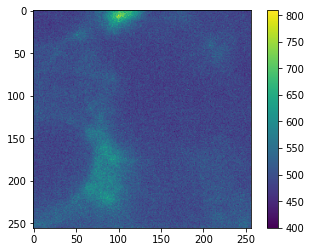

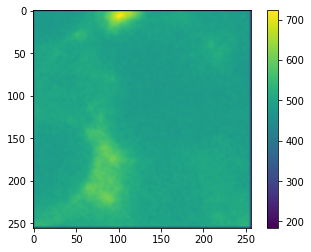

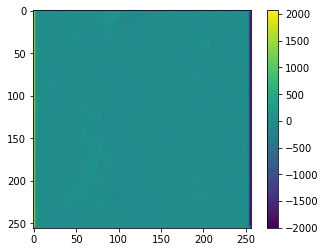

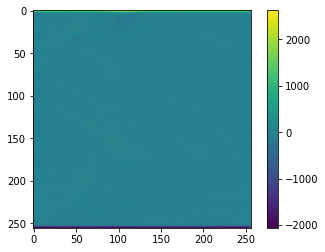

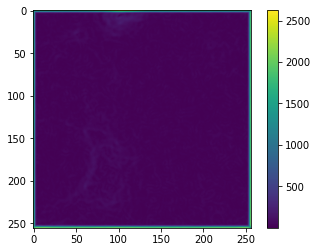

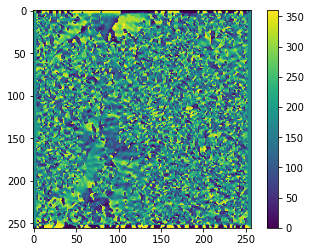

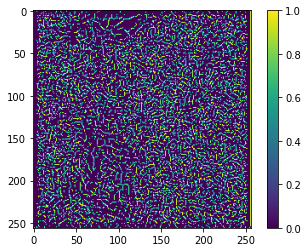

In [145]:
name = 'ls_step15'

train_loader, valid_loader = import_ls(
                                        name=name, 
                                        batch_size=32, 
                                        image_size = 256,
                                        transform = None,
                                        force_download = False)

x,y = next(iter(valid_loader))
show_fig(x[0,0], norm=False, colorbar = True)
x = CannyFilter(k_gaussian=5,k_sobel=5)(x,low_threshold=0.1, high_threshold=0.3,hysteresis=True)
blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges = x
for img in x:
    show_fig(img[0,0].detach(), norm=False, colorbar = True)